# Basic classification: Classify images of clothing
A tensorflow serving style service example using MLFlow


![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=tensorflow&ea=tensorflow_2_fashion_mnist&dt=tensorflow_2_fashion_mnist)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
NAME = 'fashion_mnist_mlflow'

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import io

# TensorFlow
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


Ankle boot


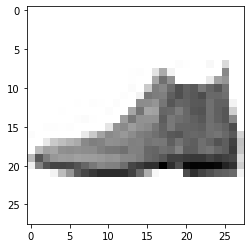

In [5]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(_train_images, train_labels), (_test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
train_images = _train_images / 255.0
test_images = _test_images / 255.0

# pick up a test image
d_test_img = _test_images[0]
print(class_names[test_labels[0]])

plt.imshow(255.0 - d_test_img, cmap='gray')

In [6]:
class FashionMnist(tf.keras.Model):
    def __init__(self):
        super(FashionMnist, self).__init__()
        self.cnn = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
        ])
    
    @staticmethod
    def image_bytes2tensor(inputs):
        inputs = tf.map_fn(lambda i: tf.io.decode_png(i, channels=1), inputs, dtype=tf.uint8)
        inputs = tf.cast(inputs, tf.float32)
        inputs = (255.0 - inputs) / 255.0
        inputs = tf.reshape(inputs, [-1, 28, 28])
        return inputs

    @tf.function(input_signature=[tf.TensorSpec(shape=(None,), dtype=tf.string)])
    def predict_image(self, inputs):
        inputs = self.image_bytes2tensor(inputs)
        return self(inputs)
    
    def call(self, inputs):
        return self.cnn(inputs)

In [7]:
model = FashionMnist()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=1)

Train on 60000 samples
60000/60000 [==============================] - 12s 197us/sample - loss: 0.4916 - accuracy: 0.8278


# Define & save MLFlow Pyfunc model

In [13]:
import os
tmpdir = 'mlflow_tmp'
tf_model_path = os.path.join(str(tmpdir), "tf.pkl")
tf.saved_model.save(model, tf_model_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: mlflow_tmp/tf.pkl/assets


In [14]:
%%writefile benchmark_mlflow_pyfunc.py
from __future__ import print_function

import os
import pickle

import base64
import pandas as pd
import numpy as np
import six

import tensorflow as tf

import mlflow
import mlflow.pyfunc
import mlflow.pyfunc.model
from mlflow.models import Model


try:
    tf.config.set_visible_devices([], 'GPU')  # disable GPU, required when served in docker
except:
    pass


def _load_pyfunc(path):
    tf_model = tf.saved_model.load(path)
    class Model:
        class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
        def predict(self, inputs):
            _bytes = [base64.b64decode(i) for i in inputs['str'].to_numpy().tolist()]
            inputs = tf.constant(_bytes, dtype=tf.string)
            outputs = tf_model.predict_image(inputs)
            output_classes = tf.math.argmax(outputs, axis=1)
            return [self.class_names[i] for i in output_classes]
    return Model()
        


if __name__ == '__main__':
    tmpdir = 'mlflow_tmp'
    tf_model_path = os.path.join(str(tmpdir), "tf.pkl")
    model_path = os.path.join(str(tmpdir), "model")

    model_config = Model(run_id="test")
    mlflow.pyfunc.save_model(path=model_path,
                             data_path=tf_model_path,
                             loader_module=os.path.basename(__file__)[:-3],
                             code_path=[__file__],
                             mlflow_model=model_config)

    reloaded_model = mlflow.pyfunc.load_pyfunc(model_path)
    print(reloaded_model)


Overwriting benchmark_mlflow_pyfunc.py


In [15]:
!rm -r {tmpdir}/model
!python benchmark_mlflow_pyfunc.py

benchmark_mlflow_pyfunc.py:52: DeprecationWarning: .. Warning:: ``mlflow.pyfunc.load_pyfunc`` is deprecated since 1.0. This method will be removed in a near future release. Use ``mlflow.pyfunc.load_model`` instead.
  reloaded_model = mlflow.pyfunc.load_pyfunc(model_path)
2020-05-15 15:33:34.942822: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2020-05-15 15:33:34.987401: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3000000000 Hz
2020-05-15 15:33:34.988298: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5555fdd917e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-05-15 15:33:34.988316: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-05-15 15:33:34.989126: I tensorflow/core/common_runtime/process_util.cc:147] Creating 

In [16]:
from bentoml.utils import detect_free_port
PORT = detect_free_port()
server_url = f'http://127.0.0.1:{PORT}/invocations'
print(server_url)

print("Run this command to launch mlflow:")
print(f"mlflow models serve -m {tmpdir}/model --port {PORT}")

http://127.0.0.1:33589/invocations
Run this command to launch mlflow:
mlflow models serve -m mlflow_tmp/model --port 33589


# generate test requests

In [17]:
import tensorflow as tf
from io import BytesIO
import matplotlib.pyplot as plt
import base64
import json
import numpy as np
import pandas as pd
import random


def get_request_producer():
    fashion_mnist = tf.keras.datasets.fashion_mnist
    (_train_images, train_labels), (_test_images, test_labels) = fashion_mnist.load_data()
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    url = server_url
    method = "POST"
    headers = {"content-type": "application/json"}
    pred_sentence =  "The acting was a bit lacking."

    def _gen_data(size=1):
        sio = BytesIO()
        
        d_test_img = _test_images[random.randint(0, len(_test_images))]
        label = class_names[test_labels[0]]
        plt.imsave(sio, 255.0 - d_test_img, cmap='gray')
        img_bytes = sio.getvalue()
    
        img_b64 = base64.b64encode(img_bytes).decode()

        raw_data = np.array([img_b64] * size)
        data = pd.DataFrame(raw_data, columns=['str']).to_json(orient='split')
        return url, method, headers, data

    return _gen_data

# test
get_request_producer()(1)

('http://127.0.0.1:33589/invocations',
 'POST',
 {'content-type': 'application/json'},
 '{"columns":["str"],"index":[0],"data":[["iVBORw0KGgoAAAANSUhEUgAAABwAAAAcCAYAAAByDd+UAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAPYQAAD2EBqD+naQAABTRJREFUSImVlk1rE10bx3\\/zmpm80aYqaSo2Wt24EQqC4E5dZiW6060bwe\\/g53DvQgU3rlxKF4LgFygmhQZj2rxMZibzdmbO3Is+M9x92qbeFwQC5zC\\/8z\\/Xdf2vo+R5nnNOSClRFAVFUQBI0xRd18\\/b+p9CuQhYRJ7n5HmOqqoMh0OePXuGbdsIIcjzHEVR2NvbK\\/cC5SHPC\\/XSEykKqnqy7c2bNwghmM\\/nZFmG67r0+33evXtX7i1gF+m4VOFsNuP9+\\/d8+fKF+XxOp9MhjmP29\\/dpNptsb29zdHREu93m8ePHvHjxgkajcbGAVcCXL1\\/y8+dP6vU6rVaLWq2GlBLLstjb2+PRo0fEcYymaURRxHg8RkrJkydPePv27X8D9no9sixjY2MD0zTJ8xwpJZqmYVkWP3784OHDhwRBgKIo2LZNmqbEcYzjONy9e\\/dc6Lk5\\/PTpE57nsb6+ThAEeJ5HHMcIIYCTCp5MJoRhSBAExHHMcrks1bbbbb5+\\/Yrrun8H\\/PjxI5ZlkaYplUoFwzAA0DQNwzAwTZNut4tpmrRaLer1Oqqqlmu1Wo3NzU0+f\\/78d8B+v0+lUsF1XQ4ODhBCoOs6uq5jGAZSSur1OnmekyQJiqJQqVTQNI3hcEiSJPi+X7bLpcAwDNF1nUajweHhIY7jlD2XJAlSSuDEDBRFIU1TACaTCYPBANd1sW2bwWBwOXAwGKDrOqqqkmUZuq4zn88Zj8e4rkuapq

## Test with requests

In [18]:
import requests
url, _, headers, data = get_request_producer()()
json_response = requests.post(url, data=data, headers=headers)
print(json_response)
print(json_response.text)

<Response [200]>
["Pullover"]


## Benchmark

In [19]:
import os


def init_file(file_name):
    if os.path.exists(LOG_FILE):
        return
    with open(file_name, "a") as lf:
        lf.write('"model name","test_users","total succ","succ/sec","avg resp time",'
                 '"total fail","fail/sec","avg fail resp time","client health"')
        lf.write('\n')


def log_result(b, name, file_name, test_user):
    init_file(file_name)
    self = b.stat

    result = []
    result.append(name)
    result.append(test_user)
    result.append(self.success)
    result.append(self.success / max(self.sess_time, 1))
    result.append(sum(self.succ_times) / max(self.success, 1))

    result.append(self.fail)
    result.append(self.fail / max(self.sess_time, 1))
    result.append(sum(self.exec_times) / max(self.fail, 1))
    
    result.append((1 - self.client_busy / max(self.req_total, 1)))

    log_str = ','.join(str(r) for r in result)
    with open(file_name, "a") as lf:
        lf.write(log_str)
        lf.write('\n')

        
LOG_FILE = 'benchmark_result.csv'

In [20]:
from bentoml.utils.benchmark import BenchmarkClient
import asyncio


for TEST_USER in range(100, 1600, 100):
    b = BenchmarkClient(get_request_producer(), lambda: 1, timeout=0.35)
    await b._start_session(60, TEST_USER, TEST_USER)
    log_result(b, f'{NAME}', LOG_FILE, TEST_USER)
    b.killall()
    await asyncio.sleep(15)

======= Session started! =======

╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │       0 │        0 │             nan │ 100.0             │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │       0 │        0 │             nan │                   │
╘══════════╧═════════╧══════════╧═════════════════╧═══════════════════╛

╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │     130 │     63.5 │        0.098831 │ 100.0             │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │       0 │      0   │      nan        │                   │
╘══════════╧═════════╧═══════

Task exception was never retrieved
future: <Task finished coro=<BenchmarkClient._start() done, defined at /opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py:268> exception=IndexError('index 10000 is out of bounds for axis 0 with size 10000',)>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py", line 308, in _start
    url, method, headers, data = self.request_producer()
  File "<ipython-input-17-9f1539ef8c16>", line 25, in _gen_data
    d_test_img = _test_images[random.randint(0, len(_test_images))]
IndexError: index 10000 is out of bounds for axis 0 with size 10000


======= Session started! =======

╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │       0 │        0 │             nan │ 100.0             │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │       0 │        0 │             nan │                   │
╘══════════╧═════════╧══════════╧═════════════════╧═══════════════════╛

╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │      34 │     16.5 │        0.711127 │ 100.0             │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │      18 │      9   │        0.651117 │                   │
╘══════════╧═════════╧═══════

Task exception was never retrieved
future: <Task finished coro=<BenchmarkClient._start() done, defined at /opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py:268> exception=IndexError('index 10000 is out of bounds for axis 0 with size 10000',)>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py", line 308, in _start
    url, method, headers, data = self.request_producer()
  File "<ipython-input-17-9f1539ef8c16>", line 25, in _gen_data
    d_test_img = _test_images[random.randint(0, len(_test_images))]
IndexError: index 10000 is out of bounds for axis 0 with size 10000



╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │     305 │      7.5 │        0.491165 │ 72.52998286693317 │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │    1446 │    130.5 │        1.48273  │                   │
╘══════════╧═════════╧══════════╧═════════════════╧═══════════════════╛

╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │     341 │       18 │        0.554453 │ 60.05774783445621 │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │    1737 │      130 │        1.24665  │                   │
╘══════════╧═════════╧══════════╧═════════════════╧═══════════

Task exception was never retrieved
future: <Task finished coro=<BenchmarkClient._start() done, defined at /opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py:268> exception=IndexError('index 10000 is out of bounds for axis 0 with size 10000',)>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py", line 308, in _start
    url, method, headers, data = self.request_producer()
  File "<ipython-input-17-9f1539ef8c16>", line 25, in _gen_data
    d_test_img = _test_images[random.randint(0, len(_test_images))]
IndexError: index 10000 is out of bounds for axis 0 with size 10000



╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │       1 │      0.5 │        0.534782 │ 80.66354311763962 │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │    7896 │    400   │        1.19179  │                   │
╘══════════╧═════════╧══════════╧═════════════════╧═══════════════════╛

╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │       1 │      0   │       nan       │ 80.02780352177943 │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │    8631 │    367.5 │         1.39439 │                   │
╘══════════╧═════════╧══════════╧═════════════════╧═══════════

Task exception was never retrieved
future: <Task finished coro=<BenchmarkClient._start() done, defined at /opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py:268> exception=IndexError('index 10000 is out of bounds for axis 0 with size 10000',)>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py", line 308, in _start
    url, method, headers, data = self.request_producer()
  File "<ipython-input-17-9f1539ef8c16>", line 25, in _gen_data
    d_test_img = _test_images[random.randint(0, len(_test_images))]
IndexError: index 10000 is out of bounds for axis 0 with size 10000



╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │       0 │      0   │       nan       │ 24.13015184381778 │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │   23050 │    111.5 │         1.97799 │                   │
╘══════════╧═════════╧══════════╧═════════════════╧═══════════════════╛

╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │       0 │        0 │       nan       │ 29.49585855367951 │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │   25112 │      577 │         1.66481 │                   │
╘══════════╧═════════╧══════════╧═════════════════╧═══════════

Task exception was never retrieved
future: <Task finished coro=<BenchmarkClient._start() done, defined at /opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py:268> exception=IndexError('index 10000 is out of bounds for axis 0 with size 10000',)>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py", line 308, in _start
    url, method, headers, data = self.request_producer()
  File "<ipython-input-17-9f1539ef8c16>", line 25, in _gen_data
    d_test_img = _test_images[random.randint(0, len(_test_images))]
IndexError: index 10000 is out of bounds for axis 0 with size 10000



╒══════════╤═════════╤══════════╤═════════════════╤════════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %    │
╞══════════╪═════════╪══════════╪═════════════════╪════════════════════╡
│ succ     │       1 │      0   │        nan      │ 52.165940866376346 │
├──────────┼─────────┼──────────┼─────────────────┼────────────────────┤
│ fail     │    4362 │    341.5 │          1.5002 │                    │
╘══════════╧═════════╧══════════╧═════════════════╧════════════════════╛

╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │       1 │        0 │       nan       │ 54.73281050519788 │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │    5482 │      161 │         1.99593 │                   │
╘══════════╧═════════╧══════════╧═════════════════╧════

Task exception was never retrieved
future: <Task finished coro=<BenchmarkClient._start() done, defined at /opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py:268> exception=IndexError('index 10000 is out of bounds for axis 0 with size 10000',)>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py", line 308, in _start
    url, method, headers, data = self.request_producer()
  File "<ipython-input-17-9f1539ef8c16>", line 25, in _gen_data
    d_test_img = _test_images[random.randint(0, len(_test_images))]
IndexError: index 10000 is out of bounds for axis 0 with size 10000
Task exception was never retrieved
future: <Task finished coro=<BenchmarkClient._start() done, defined at /opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py:268> exception=IndexError('index 10000 is out of bounds for axis 0 with size 10000',)>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/bentoml/util


╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │       1 │        0 │       nan       │ 53.56978350990327 │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │    8683 │      412 │         2.09319 │                   │
╘══════════╧═════════╧══════════╧═════════════════╧═══════════════════╛

╒══════════╤═════════╤══════════╤═════════════════╤════════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %    │
╞══════════╪═════════╪══════════╪═════════════════╪════════════════════╡
│ succ     │       1 │      0   │       nan       │ 54.772634166325275 │
├──────────┼─────────┼──────────┼─────────────────┼────────────────────┤
│ fail     │    9763 │    352.5 │         1.72816 │                    │
╘══════════╧═════════╧══════════╧═════════════════╧═════

Task exception was never retrieved
future: <Task finished coro=<BenchmarkClient._start() done, defined at /opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py:268> exception=IndexError('index 10000 is out of bounds for axis 0 with size 10000',)>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py", line 308, in _start
    url, method, headers, data = self.request_producer()
  File "<ipython-input-17-9f1539ef8c16>", line 25, in _gen_data
    d_test_img = _test_images[random.randint(0, len(_test_images))]
IndexError: index 10000 is out of bounds for axis 0 with size 10000


======= Session started! =======

╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │       0 │        0 │             nan │ 100.0             │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │       0 │        0 │             nan │                   │
╘══════════╧═════════╧══════════╧═════════════════╧═══════════════════╛

╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │       0 │        0 │       nan       │ 100.0             │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │     234 │      117 │         1.25573 │                   │
╘══════════╧═════════╧═══════

Task exception was never retrieved
future: <Task finished coro=<BenchmarkClient._start() done, defined at /opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py:268> exception=IndexError('index 10000 is out of bounds for axis 0 with size 10000',)>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py", line 308, in _start
    url, method, headers, data = self.request_producer()
  File "<ipython-input-17-9f1539ef8c16>", line 25, in _gen_data
    d_test_img = _test_images[random.randint(0, len(_test_images))]
IndexError: index 10000 is out of bounds for axis 0 with size 10000



╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │       0 │      0   │       nan       │ 49.55696202531645 │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │   14220 │    319.5 │         1.90452 │                   │
╘══════════╧═════════╧══════════╧═════════════════╧═══════════════════╛

╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │       0 │      0   │       nan       │ 52.56839204880929 │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │   15243 │    329.5 │         1.87792 │                   │
╘══════════╧═════════╧══════════╧═════════════════╧═══════════

Task exception was never retrieved
future: <Task finished coro=<BenchmarkClient._start() done, defined at /opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py:268> exception=IndexError('index 10000 is out of bounds for axis 0 with size 10000',)>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py", line 308, in _start
    url, method, headers, data = self.request_producer()
  File "<ipython-input-17-9f1539ef8c16>", line 25, in _gen_data
    d_test_img = _test_images[random.randint(0, len(_test_images))]
IndexError: index 10000 is out of bounds for axis 0 with size 10000



╒══════════╤═════════╤══════════╤═════════════════╤════════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %    │
╞══════════╪═════════╪══════════╪═════════════════╪════════════════════╡
│ succ     │       0 │        0 │       nan       │ 56.908321579689705 │
├──────────┼─────────┼──────────┼─────────────────┼────────────────────┤
│ fail     │   17725 │      347 │         2.25252 │                    │
╘══════════╧═════════╧══════════╧═════════════════╧════════════════════╛

╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │       0 │      0   │       nan       │ 58.14113415150233 │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │   18904 │    416.5 │         1.91114 │                   │
╘══════════╧═════════╧══════════╧═════════════════╧════

Task exception was never retrieved
future: <Task finished coro=<BenchmarkClient._start() done, defined at /opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py:268> exception=IndexError('index 10000 is out of bounds for axis 0 with size 10000',)>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py", line 308, in _start
    url, method, headers, data = self.request_producer()
  File "<ipython-input-17-9f1539ef8c16>", line 25, in _gen_data
    d_test_img = _test_images[random.randint(0, len(_test_images))]
IndexError: index 10000 is out of bounds for axis 0 with size 10000
